In [2]:
!pip install rasterio
!pip install geopandas

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 23.0 MB/s eta 0:00:00


# original version

In [3]:
import rasterio
from rasterio.merge import merge
from rasterio.plot import show
import os
import geopandas as gpd

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
# directory of tif
root_path = '/content/drive/MyDrive/icebergtrack/iceberg_sentinel/tif/'
# dir_list = [d for d in os.listdir(root_path)][1:]
# dir_list = ['/content/drive/MyDrive/icebergtrack/iceberg_sentinel/tif']

# directory of geopackage
poly_path = '/content/drive/MyDrive/icebergtrack/iceberg_sentinel/greenland_test2.gpkg'
gdf = gpd.read_file(poly_path)

# Load and extract the geometries in the GeoPackage file
geom = gdf.geometry

In [11]:
# for folder in dir_list:
    # dirpath = f'/media/laserglaciers/upernavik/iceberg_py/sam/upvk/{folder}/'
    # op =  f'/media/laserglaciers/upernavik/iceberg_py/sam/upvk/mosiacs/'
    # if not os.path.exists(op):
    #     os.makedirs(op)



tifs = [tif for tif in os.listdir(root_path) if tif.endswith('tif')]

src_files_to_mosaic = []
os.chdir(root_path[0])
for fp in tifs:
    src = rasterio.open(os.path.join(root_path, fp))
    src_files_to_mosaic.append(src)

mosaic, out_trans = merge(src_files_to_mosaic)

# show(mosaic)

out_meta = src.meta.copy()
out_meta.update({"driver": "GTiff",
                  "height": mosaic.shape[1],
                  "width": mosaic.shape[2],
                  "transform": out_trans
                  }
            )

with rasterio.open(f'{root_path[0]}_mosiac.tif',mode='w', **out_meta) as dst:
    dst.write(mosaic)

IndexError: list index out of range

# try to solve MergeError: negative pixel height

In [ ]:
import os
import numpy as np
import rasterio
from rasterio.merge import merge
from rasterio.io import MemoryFile
from rasterio.transform import Affine

# Define the root path to the directory containing TIFF files
root_path = '/content/drive/MyDrive/icebergtrack/iceberg_sentinel/tif/'
tifs = [tif for tif in os.listdir(root_path) if tif.endswith('.tif')]
src_files_to_mosaic = []

# Loop through all TIFF files
for tif in tifs:
    src_path = os.path.join(root_path, tif)
    # Open the raster file
    with rasterio.open(src_path) as src:
        # Get the affine transform of the raster
        transform = src.transform
        print(f"Processing {tif}")
        print(f"Original Transform: {transform}")

        # Check if the pixel height is negative
        if transform.e < 0:
            print(f"Raster {tif} has negative pixel height. Correcting...")
            # Calculate new transform with positive pixel height
            new_transform = Affine(
                transform.a,
                transform.b,
                transform.c,
                transform.d,
                -transform.e,  # Make pixel height positive
                transform.f + (transform.e * src.height)  # Adjust the origin
            )
            print(f"New Transform: {new_transform}")

            # Update metadata with the new transform
            kwargs = src.meta.copy()
            kwargs.update({
                'transform': new_transform,
                'height': src.height,
                'width': src.width
            })

            # Read the data from the source raster
            data = src.read()
            # Flip the data vertically (along the y-axis)
            data_flipped = np.flipud(data)
            print(f"Data flipped for raster {tif}")

            # Write the corrected raster to a MemoryFile
            memfile = MemoryFile()
            with memfile.open(**kwargs) as dataset:
                dataset.write(data_flipped)
                # Append the in-memory dataset to the list
                src_files_to_mosaic.append(dataset)
        else:
            print(f"Raster {tif} has positive pixel height.")
            # For rasters with positive pixel height, append directly
            src_files_to_mosaic.append(src)

# Now merge the datasets
print("Merging rasters...")
mosaic, out_trans = merge(src_files_to_mosaic)

# Close all datasets in src_files_to_mosaic
for src in src_files_to_mosaic:
    src.close()

# Define output metadata
out_meta = src.meta.copy()
out_meta.update({
    "driver": "GTiff",
    "height": mosaic.shape[1],
    "width": mosaic.shape[2],
    "transform": out_trans,
    "crs": src.crs
})

# Specify the output path for the mosaic
output_path = '/content/drive/MyDrive/icebergtrack/iceberg_sentinel/mosaic.tif'

# Write the mosaic to disk
with rasterio.open(output_path, "w", **out_meta) as dest:
    dest.write(mosaic)

print(f"Mosaic saved to {output_path}")



Processing mark9.tif
Original Transform: | 1.00, 0.00, 0.00|
| 0.00, 1.00, 0.00|
| 0.00, 0.00, 1.00|
Raster mark9.tif has positive pixel height.
Processing mark8.tif
Original Transform: | 1.00, 0.00, 0.00|
| 0.00, 1.00, 0.00|
| 0.00, 0.00, 1.00|
Raster mark8.tif has positive pixel height.
Merging rasters...


RasterioIOError: Dataset is closed: /content/drive/MyDrive/icebergtrack/iceberg_sentinel/tif/mark9.tif

# try simpler

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
import rasterio
from rasterio.merge import merge
from rasterio.warp import calculate_default_transform, reproject, Resampling
from rasterio.crs import CRS

In [7]:
# Load images using rasterio
image_paths = ['/content/drive/MyDrive/icebergtrack/iceberg_sentinel/tif/merge/11.tif',
               '/content/drive/MyDrive/icebergtrack/iceberg_sentinel/tif/merge/22.tif',
               '/content/drive/MyDrive/icebergtrack/iceberg_sentinel/tif/merge/33.tif',
               '/content/drive/MyDrive/icebergtrack/iceberg_sentinel/tif/merge/44.tif'
               ]


In [12]:
# Reproject images if they have negative pixel height
corrected_images =[]

# Specify the desired CRS
desired_crs = CRS.from_epsg(4326)

# Reproject images if they have negative pixel height or missing CRS
for path in image_paths:
    with rasterio.open(path) as src:
        # Check if CRS is missing and assign desired CRS
        if src.crs is None:
            crs = desired_crs
        else:
            crs = src.crs

        # Calculate the default transform and dimensions
        transform, width, height = calculate_default_transform(
            crs, crs, src.width, src.height, *src.bounds
        )
        kwargs = src.meta.copy()
        kwargs.update({
            'crs': crs,
            'transform': transform,
            'width': width,
            'height': height
        })

        # Output path for reprojected image
        reprojected_path = path.replace('.tif', '_reprojected.tif')
        with rasterio.open(reprojected_path, 'w', **kwargs) as dst:
            for i in range(1, src.count + 1):
                reproject(
                    source=rasterio.band(src, i),
                    destination=rasterio.band(dst, i),
                    src_transform=src.transform,
                    src_crs=crs,
                    dst_transform=transform,
                    dst_crs=crs,
                    resampling=Resampling.nearest
                )
        corrected_images.append(reprojected_path)

In [13]:
datasets = [rasterio.open(img) for img in corrected_images]
datasets

[<open DatasetReader name='/content/drive/MyDrive/icebergtrack/iceberg_sentinel/tif/merge/11_reprojected.tif' mode='r'>,
 <open DatasetReader name='/content/drive/MyDrive/icebergtrack/iceberg_sentinel/tif/merge/22_reprojected.tif' mode='r'>,
 <open DatasetReader name='/content/drive/MyDrive/icebergtrack/iceberg_sentinel/tif/merge/33_reprojected.tif' mode='r'>,
 <open DatasetReader name='/content/drive/MyDrive/icebergtrack/iceberg_sentinel/tif/merge/44_reprojected.tif' mode='r'>]

In [14]:
# Merge images
merged, out_transform = merge(datasets)

old

In [8]:
datasets = [rasterio.open(img) for img in image_paths]

# Merge images
merged, out_transform = merge(datasets)

In [9]:
merged.shape[2]

4960

In [15]:
# Save the merged image
out_meta = src.meta.copy()
out_meta.update({"driver": "GTiff",
                  "height": merged.shape[1],
                  "width": merged.shape[2],
                  "transform": out_transform
                  }
            )

with rasterio.open('/content/drive/MyDrive/icebergtrack/iceberg_sentinel/tif/merge/merged_mosaic2.tif', mode='w', **out_meta) as dst:
    dst.write(merged)

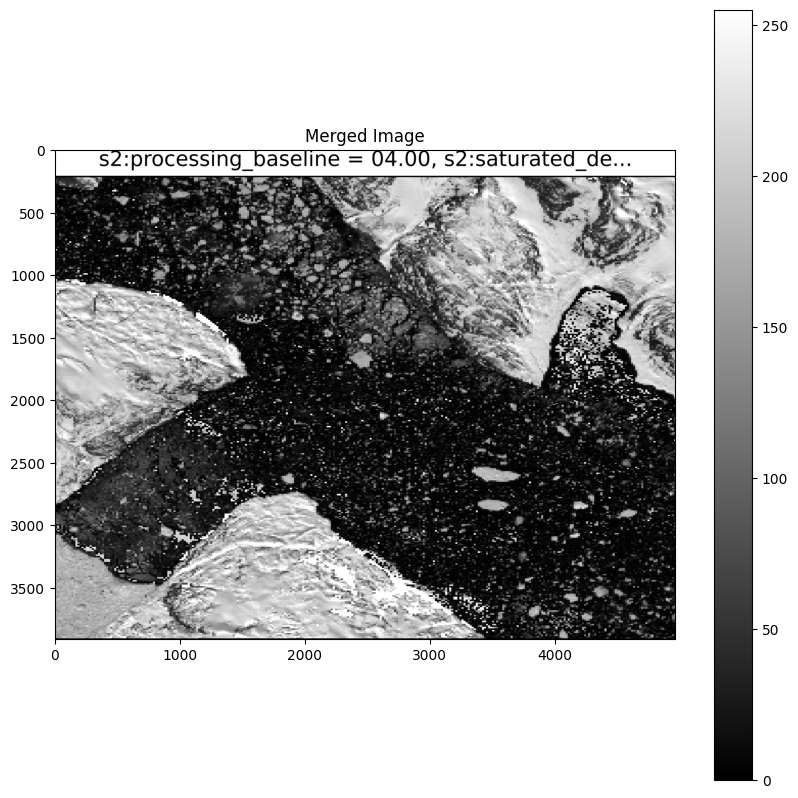

In [16]:
import matplotlib.pyplot as plt

# Open the saved merged image
with rasterio.open('/content/drive/MyDrive/icebergtrack/iceberg_sentinel/tif/merge/merged_mosaic2.tif') as merged_image:
    # Read the image data
    img_data = merged_image.read(1)  # Reads the first band; adjust if multi-band

# Display the image
plt.figure(figsize=(10, 10))
plt.imshow(img_data, cmap='gray')  # Adjust colormap as necessary
plt.colorbar()
plt.title("Merged Image")
plt.show()

In [ ]:
for i, path in enumerate(image_paths):
    with rasterio.open(path) as src:
        print(f"Bounds of image {i+1}: {src.bounds}")


Bounds of image 1: BoundingBox(left=0.0, bottom=-3907.0, right=4960.0, top=0.0)
Bounds of image 2: BoundingBox(left=0.0, bottom=-3907.0, right=4960.0, top=0.0)
Bounds of image 3: BoundingBox(left=0.0, bottom=-3907.0, right=4960.0, top=0.0)
Bounds of image 4: BoundingBox(left=0.0, bottom=-3907.0, right=4960.0, top=0.0)
